In [1]:
from itertools import chain
import numpy as np
from numpy.random import random
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

from numpy.random import random
from matplotlib import animation
from matplotlib import colors
import rasterio as rio


# set the default figure size for all the plots
plt.rcParams["figure.figsize"] = [16,9]
plt.style.use('ggplot')
plt.ion()

In [36]:
'''
Vegetation update rules: 
    (1) after 3 years without fires in herbaceous areas, the vegetation cover changes randomly 
        to one of the neighbourhood vegetation classes; 
    (2) in the shrub areas, the same process occurs with a time lapse of 10 years; 
    (3) a burned area previously not vegetated by shrub or grass becomes occupied by grass 
        with probability 0.7, shrub with probability 0.2 or by the previous vegetation
        class with probability 0.1
'''


# simulation constants
NEIGHBOROOD = np.array(((-1,0), (0,-1), (0, 1),  (1,0) ))
EMPTY, TREE, FIRE = 0, 1, 2

NOVEG, GRASS, SHRUBS, CONIFERS, OAKS, BROADLEAVES = 0, 1, 2, 3, 4, 5

grass_evolution_time = 3
shrubs_evolution_time = 10
grass_regrowth_prob =  0.7
shrubs_regrowth_prob = 0.2

# probability of a new fire
f = 4.325e-3
# Probability of vegetation growth on an empty cell
p = np.array([0, 0.75, 0.3, 0.2, 0.25, 0.1])
# Probability of vegetation propagation
g = np.array([0, 0.625, 0.4873, 0.3, 0.375, 0.075])

In [37]:
def grow(X, AGE, SPECIES):
    """Iterate the forest according to the forest-fire rules."""

    # The boundary of the forest is always empty, so only consider cells
    # indexed from 1 to nx-2, 1 to ny-2
    WX = X[1:-1, 1:-1] 
    WAGE = AGE[1:-1, 1:-1]
    WSPECIES_new = SPECIES[1:-1, 1:-1]
    WSPECIES =  WSPECIES_new.copy()
    
  
    # fire from the previous iteration becomes empty
    empty_mask = (WX == FIRE)
    WX[empty_mask] = EMPTY
    
    # update unburned pixel age
    WAGE[~empty_mask] += 1
    WAGE[empty_mask] = 0
    
    # create new trees
    empty_species = WSPECIES[empty_mask]
    tree_mask = empty_mask.copy()
    tree_mask[empty_mask] = random(empty_species.shape) < p[empty_species]
    WX[tree_mask] = TREE
    # set age to zero if new tree
    WAGE[tree_mask] = 0

    # on new trees, we are going to update vegetation according to the 3rd rule
    new_grass_mask = tree_mask & (random(WX.shape) < grass_regrowth_prob)
    WSPECIES_new[new_grass_mask] = GRASS

    new_shrubs_mask = tree_mask & (random(WX.shape) < shrubs_regrowth_prob)
    WSPECIES_new[new_shrubs_mask] = SHRUBS

    # evolve veg
    grass_mask = WSPECIES==GRASS
    shrubs_mask = WSPECIES==SHRUBS   

    evolve_grass_mask = (WAGE >= grass_evolution_time) & grass_mask
    evolve_shrubs_mask = (WAGE >= shrubs_evolution_time) & shrubs_mask    
    
    evolve_coords = zip(*np.where((evolve_grass_mask | evolve_shrubs_mask)))


    mask_zero = (WSPECIES == NOVEG)
    WX[mask_zero] = EMPTY
    WAGE[mask_zero] = 0
    
    
    for RC in evolve_coords:
        r, c = RC
        N = RC + NEIGHBOROOD
        shape_filter =  (N[:,0]>=0) & (N[:,0]<WSPECIES.shape[0]) & \
            (N[:,1]>=0) & (N[:,1]<WSPECIES.shape[1])
        N = N[shape_filter, :]
        species_around = SPECIES[N[:,0], N[:,1]]
        ev_species = species_around[species_around>WSPECIES[r,c]]

        if len(ev_species)>0:
            new_specie = np.random.choice(ev_species)
            WSPECIES_new[r, c] = new_specie

    WSPECIES[:,:] = WSPECIES_new   
    
    
def ignite(X, AGE, SPECIES):
    """Iterate the forest according to the forest-fire rules."""
    WX = X[1:-1, 1:-1] 
    
    # create new ignitions
    fire_mask = ((WX == TREE) & (random((WX.shape)) < f))
    WX[fire_mask] = FIRE



def burn(X, AGE, SPECIES):
    """propagate the ignited cells, and return the area burned for every fire"""
    # empty list that will contain the burned area of each fire in this iteration
    burned = []
    
    # create a list of r,c location where we have an ignited cell
    fires = list(zip(*np.where(X==FIRE)))
    
    for r, c in (fires):
        # at least 1 pixel was burned
        pixel_burnt = 1
        
        # create a list of burning cells for this fire
        burning_cells = [(r, c)]
        
        while len(burning_cells)>0:
            # extract the first element
            r, c = burning_cells.pop(0)
            
            # iterate the neighboorood of the extracted cell
            for dr,dc in NEIGHBOROOD:
                nr, nc = r+dr, c+dc
                
                if 0<= nr < X.shape[0] and \
                   0<= nc < X.shape[1] and \
                    X[nr, nc] == TREE:
                    specie = SPECIES[nr, nc]
                    # if it is vegetated, burn it according to probability of spread
                    if random() < g[specie]:
                        X[nr, nc] = FIRE
                        # append cell to the list of burning cell of this fire
                        burning_cells.append((nr, nc))
                        #increase the burned area for this fire
                        pixel_burnt += 1
        
        # save n of burned pixels in the list
        burned.append(pixel_burnt)
    

    return burned

0


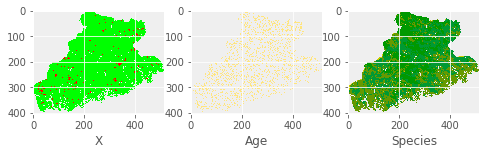

1


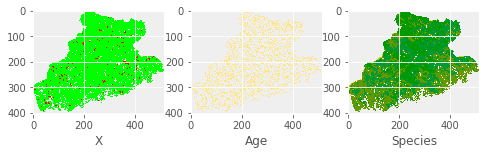

2


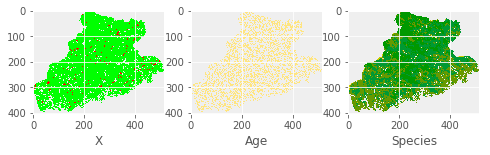

3


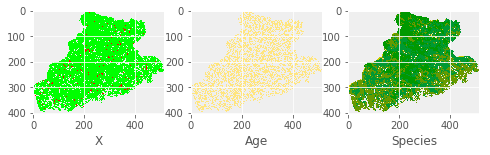

4


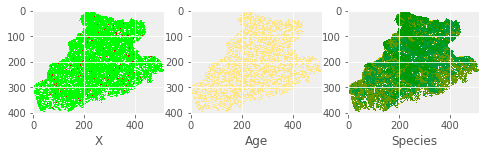

5


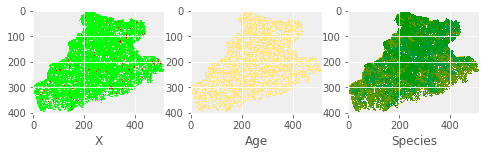

6


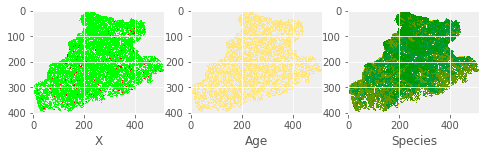

7


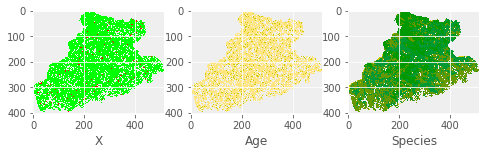

8


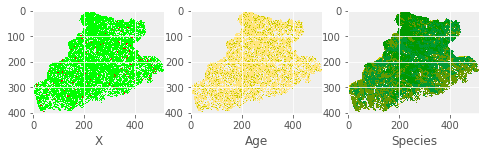

9


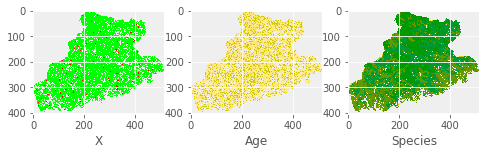

10


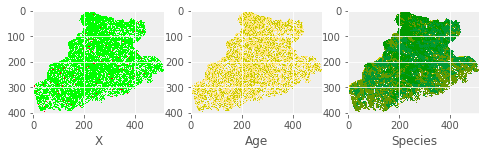

11


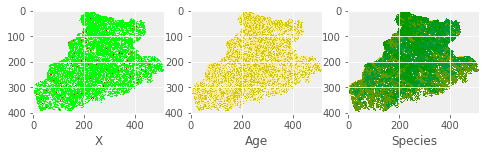

12


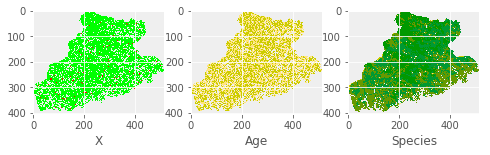

13


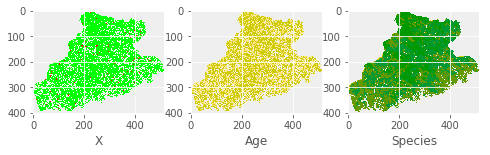

14


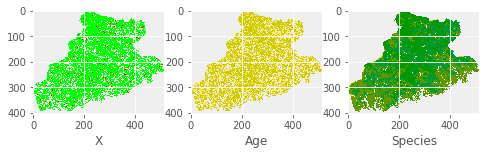

15


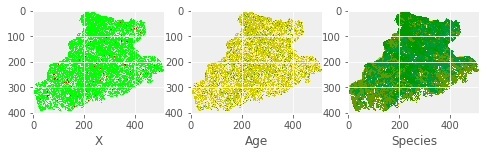

16


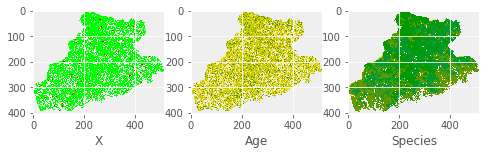

17


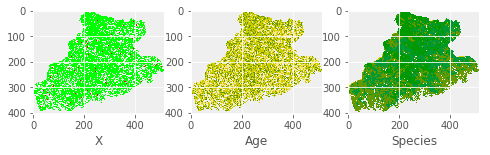

18


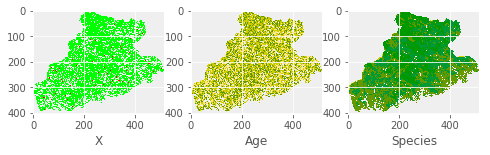

19


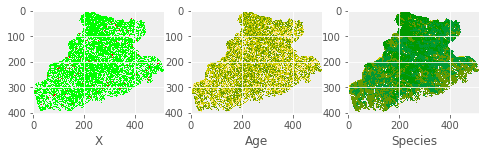

20


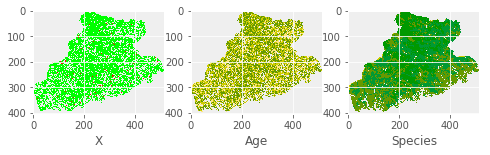

21


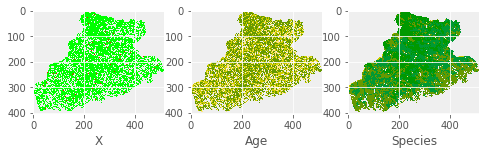

22


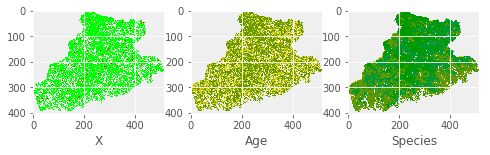

23


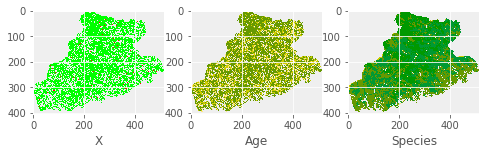

24


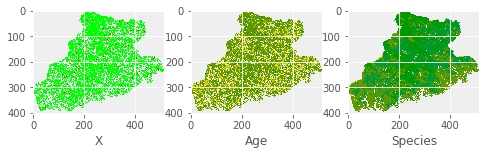

25


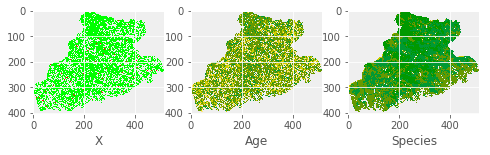

26


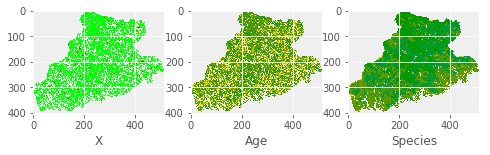

27


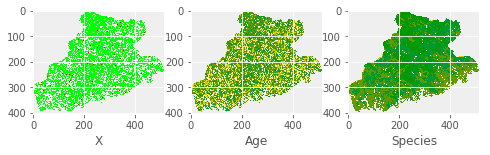

28


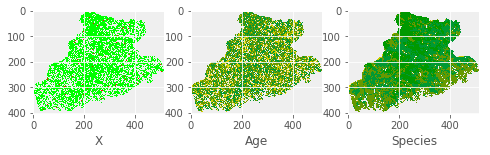

29


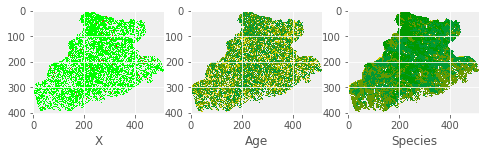

30


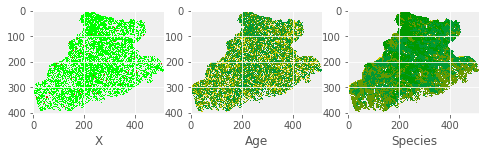

31


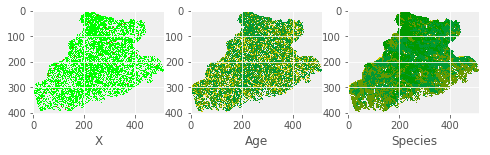

32


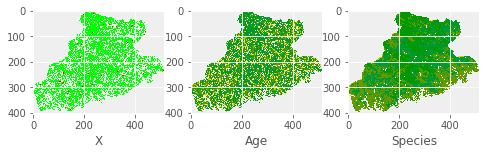

33


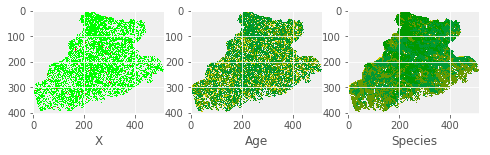

34


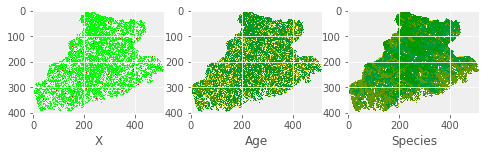

35


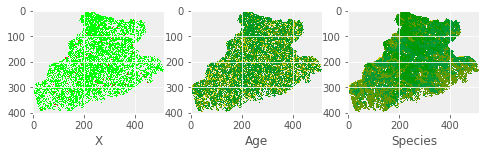

36


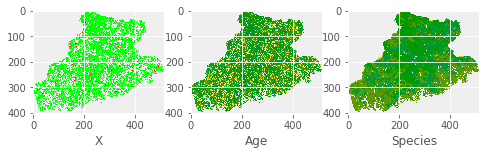

37


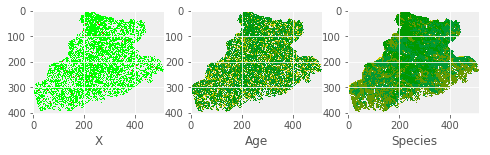

38


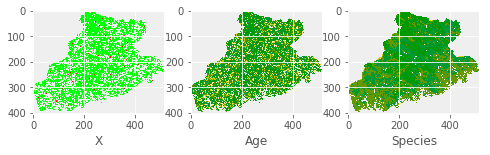

39


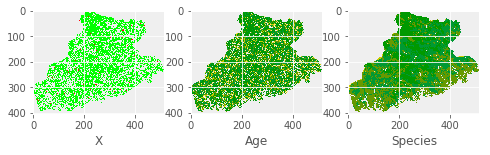

40


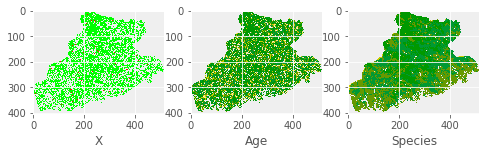

41


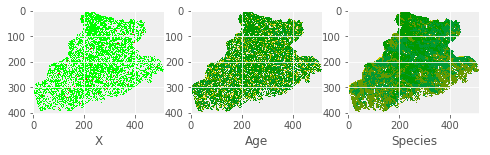

42


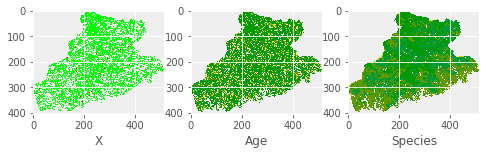

43


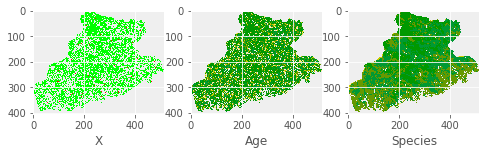

44


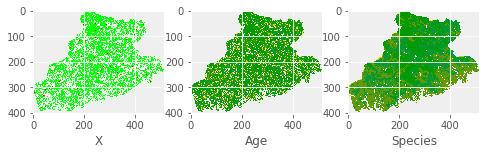

45


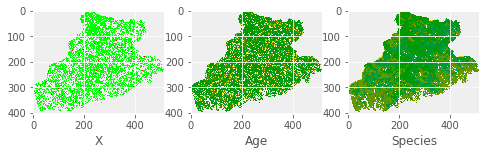

46


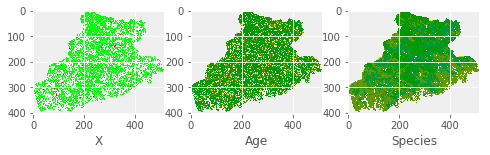

47


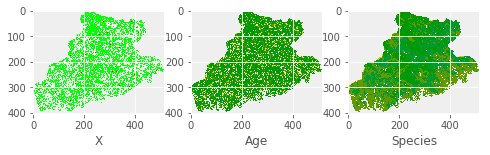

48


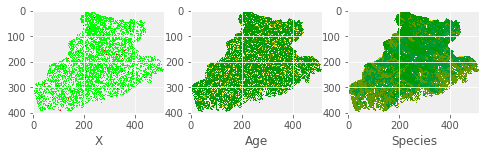

49


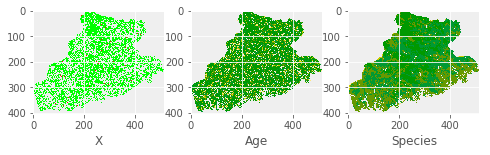

50


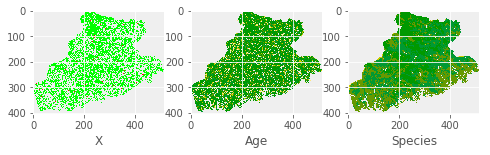

51


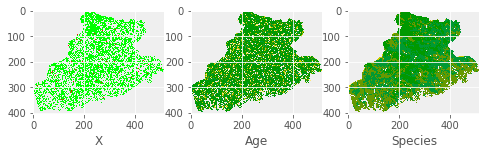

52


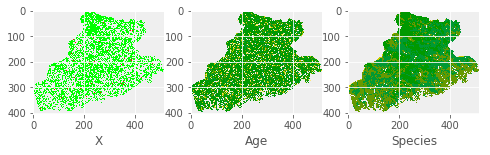

53


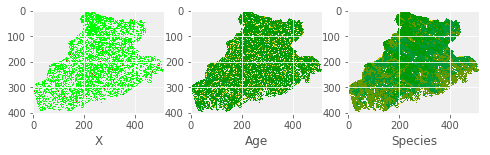

54


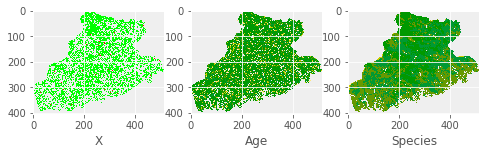

55


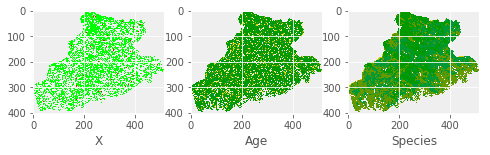

56


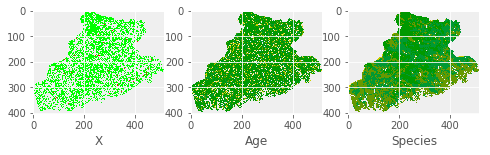

57


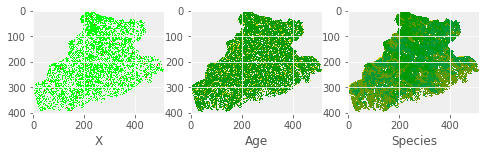

58


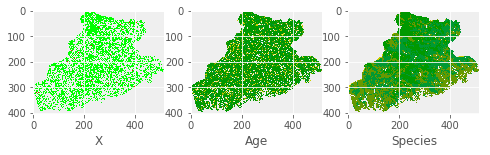

59


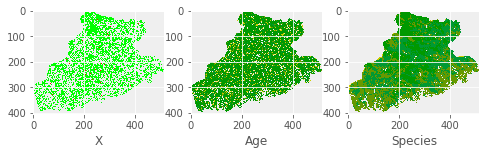

60


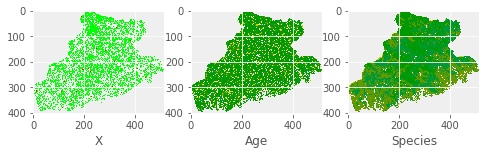

61


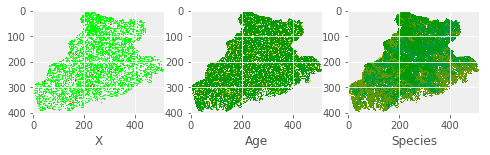

62


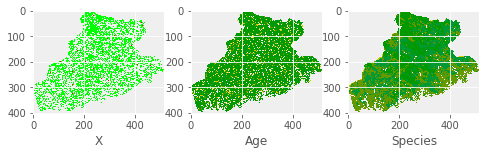

63


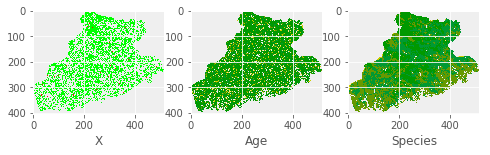

64


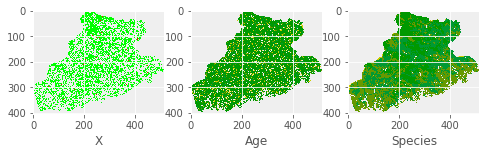

65


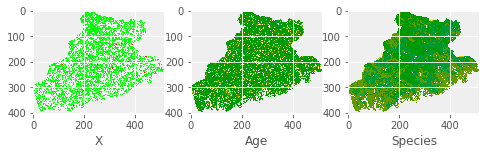

66


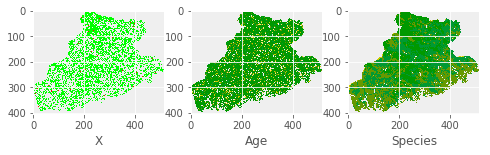

67


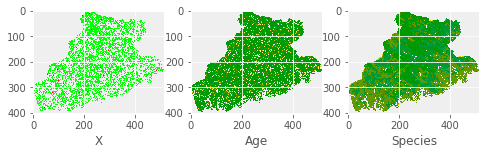

68


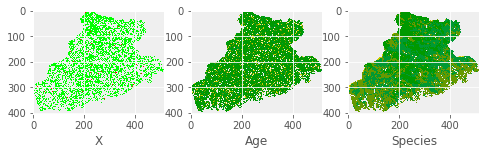

69


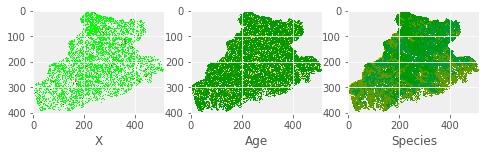

70


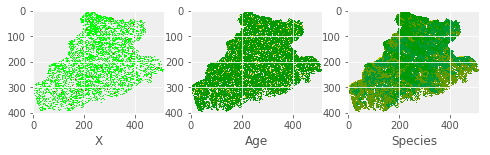

71


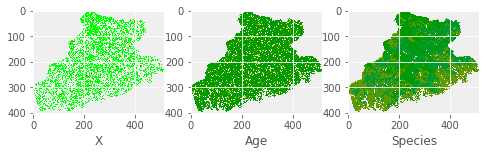

72


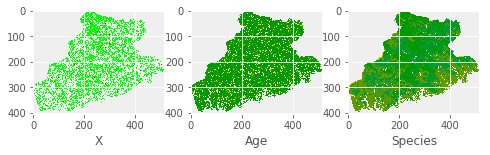

73


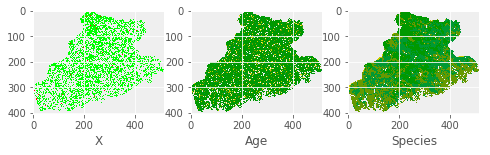

74


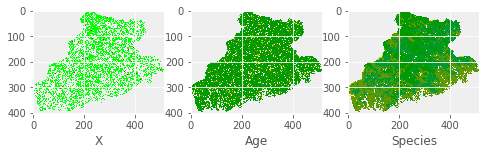

75


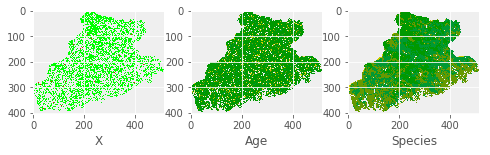

76


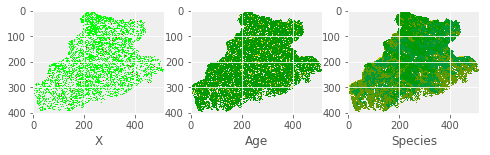

77


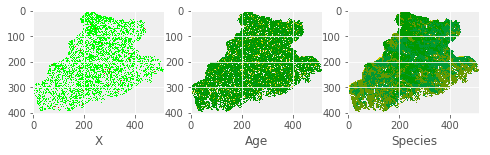

78


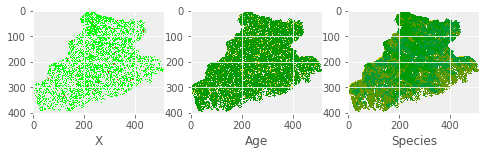

79


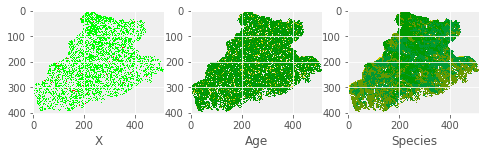

80


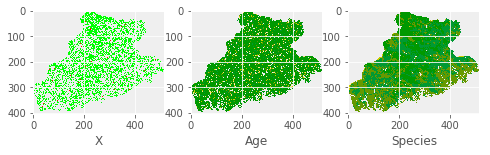

81


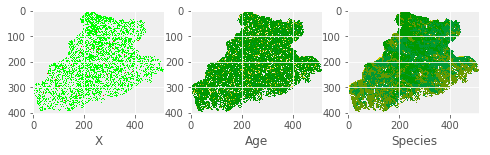

82


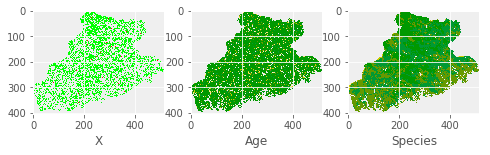

83


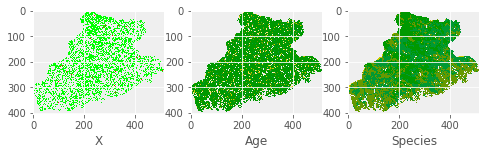

84


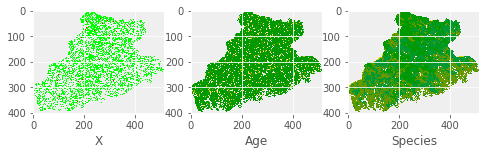

85


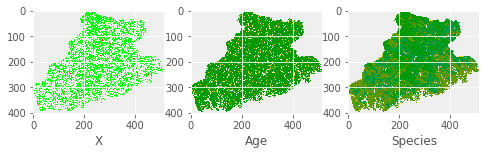

86


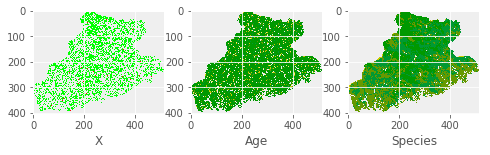

87


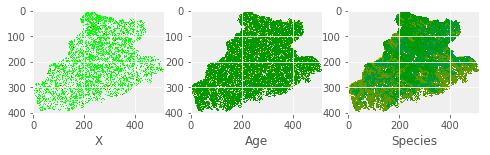

88


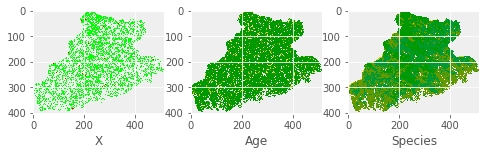

89


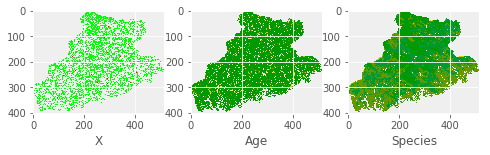

90


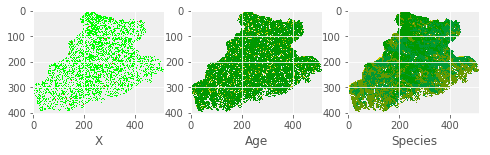

91


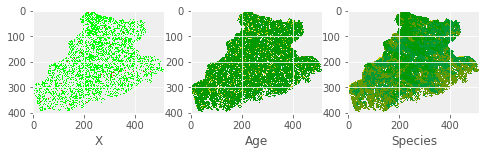

92


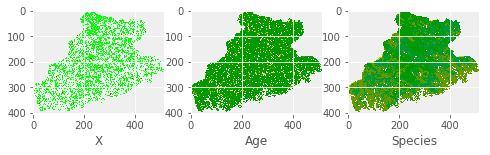

93


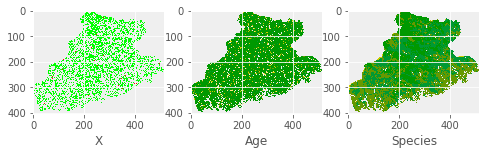

94


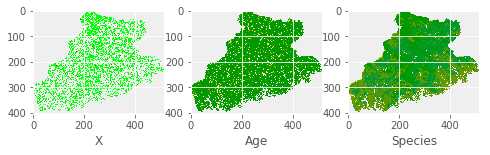

95


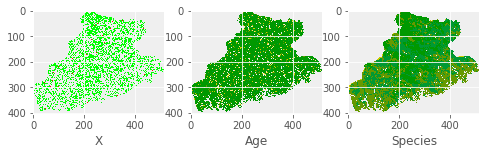

96


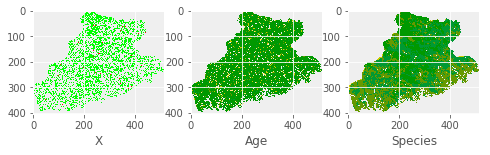

97


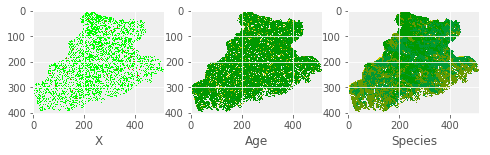

98


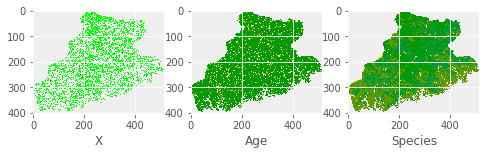

99


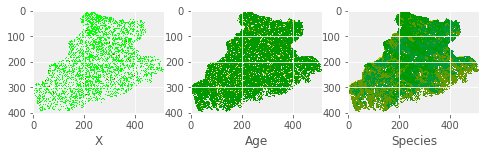

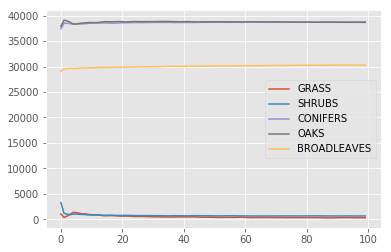

In [38]:
# Forest size (number of cells in x and y directions).

with rio.open('datasets/land_cover.tif') as src:
    band = src.read(1).astype('int')
    
#print(band.shape)
#plt.imshow(band)

# Initialize the forest grid.
X  = np.ones((band.shape))
AGE = np.random.randint(0, 10, band.shape)

SPECIES[SPECIES==-1]= NOVEG
SPECIES_ORIG = SPECIES.copy()

mask=np.where(SPECIES==NOVEG)
X[SPECIES==NOVEG] = EMPTY


#burned_list = run_simulation(X, AGE, SPECIES, 100, grow, ignite, burn)
bounds = [EMPTY, TREE, FIRE, 4]
colors_list = [(0.94, 0.94, 0.94), (0,1,0), (1,0,0), 'orange']
cmap = colors.ListedColormap(colors_list)
colors.BoundaryNorm(bounds, cmap.N)
colors_species = [(0.94, 0.94, 0.94),(1, 0.9, 0.5),(0.8,0.8,0),(0.4,0.6,0),(0,0.6,0.2),(0,0.6,0)]
cmap_species = colors.ListedColormap(colors_species)
colors_age = [(0.94, 0.94, 0.94),(1, 0.9, 0.5),(0.8,0.8,0),(0.4,0.6,0),(0,0.6,0.2),(0,0.6,0)]
cmap_age = colors.ListedColormap(colors_age)
colors.BoundaryNorm(bounds, cmap.N)

timeline = []
for i in range(0, 100):
    for ix, v in enumerate((GRASS, SHRUBS, CONIFERS, OAKS, BROADLEAVES)):
        if len(timeline)<=ix:
            timeline.append([])
        timeline[ix].append(np.sum(SPECIES==v))
        
    print(i)
    grow(X, AGE, SPECIES)
    ignite(X, AGE, SPECIES)
    burn(X, AGE, SPECIES)
    plt.figure(figsize=(8,12))
    plt.subplot(1,3,1)
    plt.imshow(X,cmap=cmap)
    plt.xlabel('X')
    plt.clim(0,3)
    plt.subplot(1,3,2)
    plt.imshow(AGE, cmap=cmap_age)
    plt.xlabel('Age')
    plt.clim(0,50)    
    plt.subplot(1,3,3)
    plt.imshow(SPECIES, cmap=cmap_species)
    plt.xlabel('Species')
    plt.clim(0,5)
    plt.show()

plt.plot(np.array(timeline).T)
plt.legend(tuple('GRASS, SHRUBS, CONIFERS, OAKS, BROADLEAVES'.split(', ')))

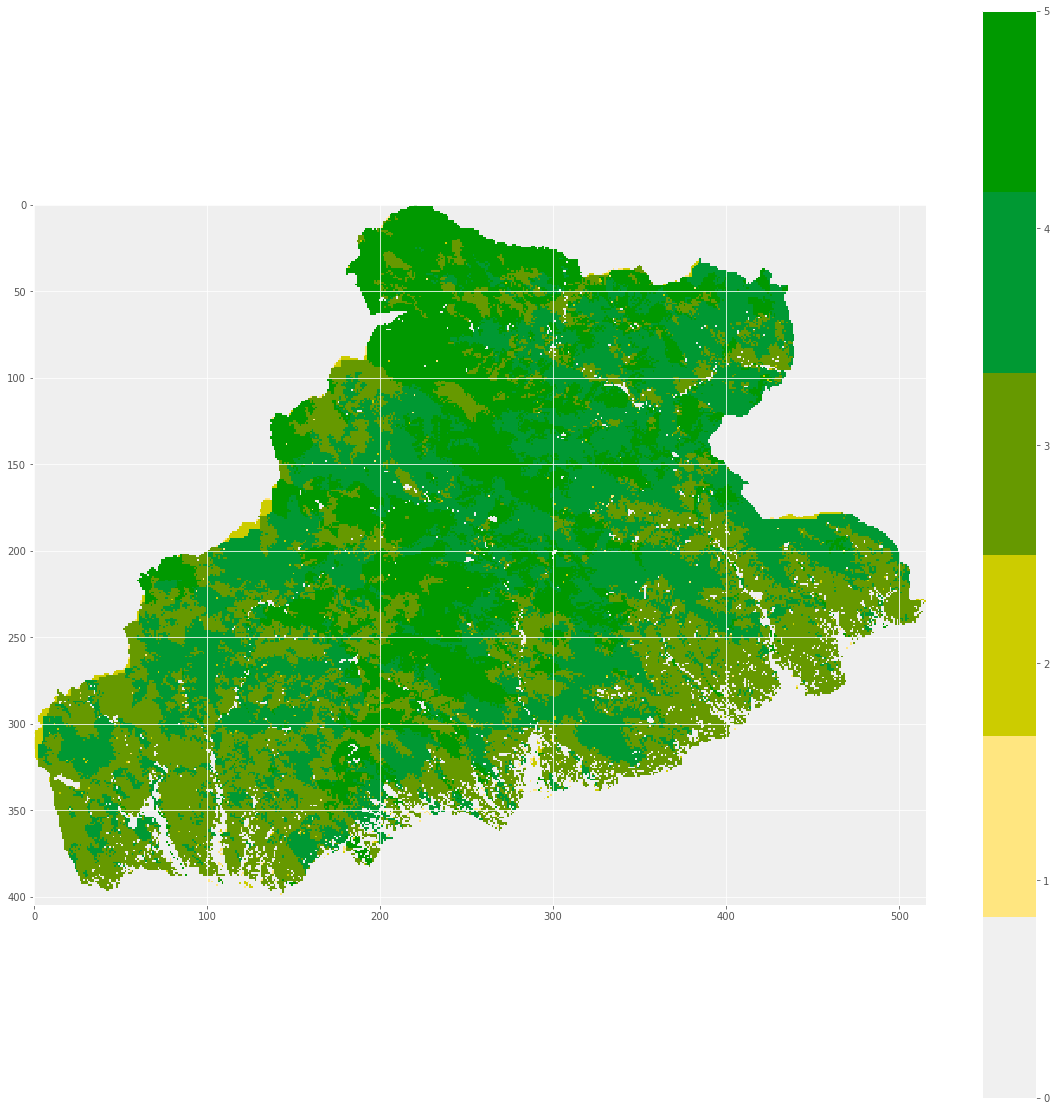

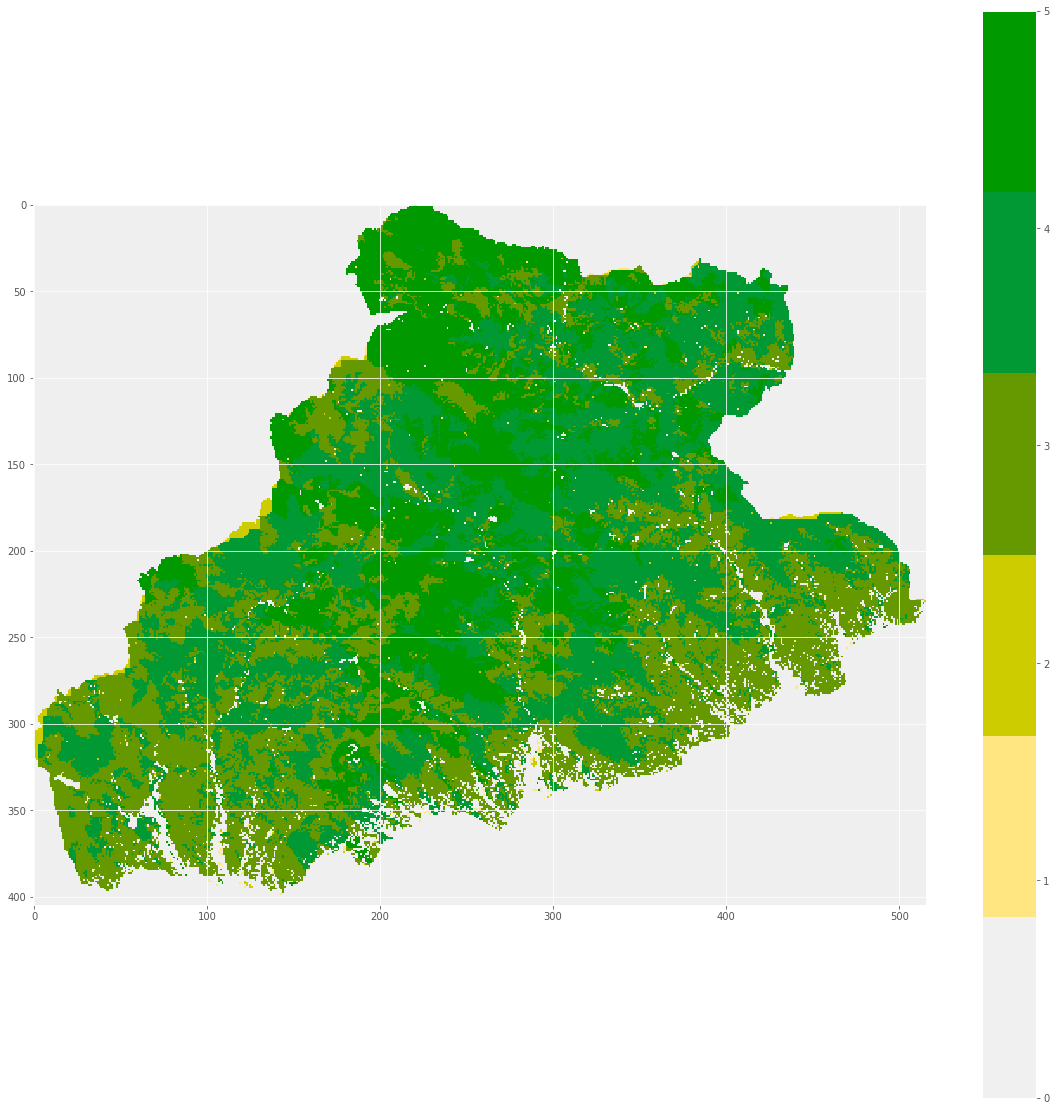

In [17]:
plt.figure(figsize=(20,20))
plt.imshow(SPECIES, cmap_species)
plt.colorbar()
plt.figure(figsize=(20,20))
plt.imshow(SPECIES_ORIG, cmap=cmap_species)
plt.colorbar()